In [1]:
import os
from functools import reduce
from itertools import combinations
import pandas as pd
import upsetplot
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(gene_dict, groups):
    # get the set of gene combinations for each group
    gene_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_genes = list(combinations(groups, i))
        for genes in all_genes:
            # get counts of elements that are unique to the combinations
            include_genes = genes
            exclude_genes = tuple(g for g in groups if g not in include_genes)
            include_sets = [gene_dict[c] for c in include_genes]
            exclude_sets = [gene_dict[c] for c in exclude_genes]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_genes, exclude_genes)] = unique_intersects
            for c in include_genes:
                gene_boolean_dict[c].append(True)
            for c in exclude_genes:
                gene_boolean_dict[c].append(False)
    gene_boolean_dict["counts"] = counts
    df = pd.DataFrame(gene_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

def plot_upset(groups, group_genes, figsize):
    gene_dict = {group:genes for group, genes in zip(groups, group_genes)}
    upset_df, uniq_inter = get_upset_df(gene_dict,  groups)
    parsed_upset_df = upset_df.loc[upset_df.counts>0]
    fig = plt.figure(figsize=figsize)
    up_fig = upsetplot.plot(parsed_upset_df.counts, show_counts=True, fig=fig,  element_size=None)
    return up_fig, upset_df, uniq_inter

In [23]:
def get_genes(filename):
    df = pd.read_csv(filename)
    sig_df = df.loc[df.padj<0.05]
    return set(sig_df.index.to_list())

def get_downregulated_genes(filename):
    df = pd.read_csv(filename)
    sig_df = df.loc[df.padj<0.05]
    sig_df = sig_df.loc[sig_df.log2FoldChange<0]
    return set(sig_df.index.to_list())

def get_upregulated_genes(filename):
    df = pd.read_csv(filename)
    sig_df = df.loc[df.padj<0.05]
    sig_df = sig_df.loc[sig_df.log2FoldChange>=0]
    return set(sig_df.index.to_list())

In [28]:
lib_names = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]
lib_de_files = [os.path.join("../data/results/de/", f"{lib}vsCC", "de_results.csv") for lib in lib_names]
lib_gene_dict = {ln:get_genes(lnf) for ln, lnf in zip(lib_names, lib_de_files)}

In [29]:
upset_df, uniq_inter = get_upset_df(lib_gene_dict,  lib_names[:-1])

In [30]:
parsed_upset_df = upset_df.loc[upset_df.counts>0]

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

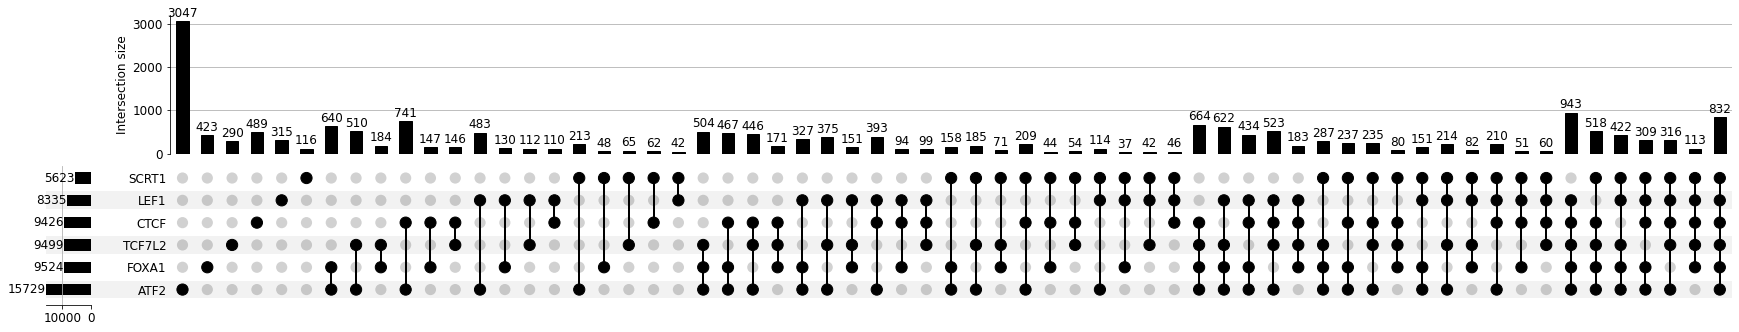

In [31]:
upsetplot.plot(parsed_upset_df.counts, show_counts=True)